# Mod 4 Project - Time Series

* Student name: THOMAS J WHIPPLE
* Student pace: part time student
* Scheduled project review date/time: FRIDAY, MAY 22, 2020, 10:00am
* Instructor name: ABHINEET KULKARNI
* Blog post URL:  https://medium.com/@mrtjwhipple/zillow-time-series-352ed141a4a


## Zillow Small Dataset Predictor

For this Flatiron Module 4 project, I will be forecasting real estate prices of various zip codes using data from the small Zillow dataset. I will be acting as a consultant for a fictional real-estate investment firm and need to build a time series model to justify my findings. The firm has asked me to determine:

> What zip codes of New England’s villages will bring the best five year future return?


# Import Necessary Libraries

In [1]:
# Below are the libraries I will use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

import itertools
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

np.random.seed(123) 

# Load the Data

In [2]:
# Load the data
df = pd.read_csv("zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
# 14723 zip codes in total
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# Data Preprocessing

In [4]:
# Change RegionName to Zipcode
df = df.rename(columns={'RegionName': 'Zipcode'})
df.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
# What is this column about?
df.SizeRank.describe()

count    14723.000000
mean      7362.000000
std       4250.308342
min          1.000000
25%       3681.500000
50%       7362.000000
75%      11042.500000
max      14723.000000
Name: SizeRank, dtype: float64

In [6]:
# What is the RegionID column?
df.RegionID.describe()

count     14723.000000
mean      81075.010052
std       31934.118525
min       58196.000000
25%       67174.500000
50%       78007.000000
75%       90920.500000
max      753844.000000
Name: RegionID, dtype: float64

In [7]:
# Drop these unnecessary columns
df = df.drop(['RegionID', 'SizeRank'], axis = 1)
df.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [8]:
# Check out the different counties
df.CountyName.describe()

count           14723
unique           1212
top       Los Angeles
freq              264
Name: CountyName, dtype: object

In [9]:
# Found some interesting county names!
df.CountyName.unique()

array(['Cook', 'Collin', 'Harris', ..., 'Sunflower', 'Jewell', 'Licking'],
      dtype=object)

In [10]:
# Of course New York is at the top here
df.Metro.describe()

count        13680
unique         701
top       New York
freq           779
Name: Metro, dtype: object

In [11]:
# And of course California is represented fully
df.State.describe()

count     14723
unique       51
top          CA
freq       1224
Name: State, dtype: object

In [12]:
# My hometown state is pretty small
df[df.State == 'VT'].count()

Zipcode       16
City          16
State         16
Metro         16
CountyName    16
              ..
2017-12       16
2018-01       16
2018-02       16
2018-03       16
2018-04       16
Length: 270, dtype: int64

In [13]:
# Mostly around Burlington and the capital
df[df.State == 'VT']

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6146,5641,Barre,VT,Barre,Washington,86600.0,86100.0,85700.0,85300.0,84900.0,...,168700,170100,172100,173200,172700,171400,169500,167900,166900,166200
6188,5478,Saint Albans,VT,Burlington,Franklin,102800.0,102300.0,101900.0,101400.0,101000.0,...,208700,209600,209200,208200,207400,207200,207900,208900,210300,211500
7185,5602,Montpelier,VT,Barre,Washington,98500.0,98200.0,97800.0,97500.0,97100.0,...,247400,249200,251900,254000,254700,253100,249400,246400,244900,243500
9222,5488,Swanton,VT,Burlington,Franklin,104200.0,103700.0,103200.0,102700.0,102200.0,...,193500,193600,192800,192200,192200,192600,193000,193700,194500,195300
10300,5676,Waterbury,VT,Barre,Washington,85100.0,84900.0,84800.0,84600.0,84400.0,...,253700,255700,259000,261900,262900,261300,258100,255400,253200,251300
10687,5450,Enosburg Falls,VT,Burlington,Franklin,37500.0,37400.0,37400.0,37400.0,37400.0,...,166000,166000,165500,165400,165700,166200,167000,167300,167200,167300
10897,5663,Northfield,VT,Barre,Washington,91900.0,91600.0,91300.0,90900.0,90700.0,...,172900,173600,175400,177400,178200,177400,175700,174100,173300,172900
10991,5454,Fairfax,VT,Burlington,Franklin,132900.0,132000.0,131200.0,130300.0,129300.0,...,255800,256900,256500,256100,256400,257200,258100,259300,260600,261800
11464,5673,Fayston,VT,Barre,Washington,77500.0,77200.0,76800.0,76400.0,76100.0,...,318600,320400,324700,328400,330700,330000,325700,321200,319700,318800
12383,5476,Richford,VT,Burlington,Franklin,52400.0,52000.0,51600.0,51200.0,50800.0,...,106000,105800,104300,103300,102600,101800,102300,104400,106100,107200


In [14]:
# My Vermont zip code is not in the set.
df[df.Zipcode == 5156].count()

Zipcode       0
City          0
State         0
Metro         0
CountyName    0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 270, dtype: int64

# EDA - Exploratory Data Analysis

As many New Yorkers and Bostonians may be thinking about moving out of the city over the next few years I will be focusing on small villages in the Northeast. My business plan involves determining the New England zip code that will bring the highest return in the next five years as potential investments as well as places to move. A village will be considered any town that is between 10,000 and 15,000 people as we hope to find small, quaint centers that aren't suburbs of large metro areas but still have some commerce. For sake of diversity, we will narrow the field down to the top two zip codes in each of the six New England states.

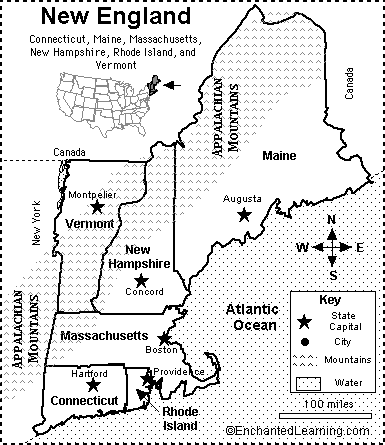

In [105]:
# I viewed this map of the New England states.
from IPython.display import Image 
Image("../dsc-mod-4-project-v2-1-online-ds-pt-090919/new_england.gif")

## Filtering for Chosen Zipcodes 
I need to narrow down my 14,723 zipcodes... down to twelve... and then one!

### New England zip codes

In [16]:
# New England zipcodes all begin with zero and therefore have only four digits
NE_zips = df.loc[df['Zipcode'] < 9999]
NE_zips.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
57,7030,Hoboken,NJ,New York,Hudson,301600.0,302700.0,303800.0,304800.0,305800.0,...,1789100,1803000,1818100,1836900,1850100,1853500,1852200,1854400,1857600,1854300
73,8701,Lakewood,NJ,New York,Ocean,153800.0,153400.0,153000.0,152500.0,152200.0,...,400500,403900,408400,411000,412600,414000,415700,415600,413400,410700
88,2169,Quincy,MA,Boston,Norfolk,137800.0,137900.0,137900.0,138000.0,138100.0,...,416900,417800,421100,425100,428600,431900,435700,440500,445800,449100
112,6010,Bristol,CT,Hartford,Hartford,120300.0,120000.0,119800.0,119400.0,119100.0,...,188900,190000,191200,191800,192900,193600,194100,194900,195700,195700
149,2148,Malden,MA,Boston,Middlesex,130600.0,130700.0,130800.0,131000.0,131200.0,...,439100,442400,446700,451400,454700,457700,461900,466000,469300,471100


In [17]:
# Down to about 10% of the data
NE_zips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1403 entries, 57 to 14719
Columns: 270 entries, Zipcode to 2018-04
dtypes: float64(219), int64(47), object(4)
memory usage: 2.9+ MB


In [18]:
# There should be six New England states!
NE_zips.State.unique()

array(['NJ', 'MA', 'CT', 'ME', 'RI', 'NH', 'VT'], dtype=object)

In [19]:
# I viewed this map of the New England states.
from IPython.display import Image
from IPython.core.display import HTML 
basin_url = ("https://newengland.com/wp-content/uploads/new-england-states-map.jpg")
Image(url=basin_url, width=500, height=400)

In [20]:
# Whooops, New Jersey is not a part of New England!
NE_zips.drop(NE_zips[NE_zips['State'] == 'NJ'].index, inplace=True) 

/Users/whipxach/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
# The five New England states: 'MA', 'CT', 'ME', 'RI', 'NH', 'VT'
NE_zips.State.unique()

array(['MA', 'CT', 'ME', 'RI', 'NH', 'VT'], dtype=object)

In [22]:
# Still have a long way to go
NE_zips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 88 to 14719
Columns: 270 entries, Zipcode to 2018-04
dtypes: float64(219), int64(47), object(4)
memory usage: 1.9+ MB


In [23]:
# This seems correct, as the rest were in NY and NJ
NE_zips.Zipcode.max()

6897

## Zipcodes by Population

Again, in order to stick to the business plan, we will be cross referencing only the zip codes for villages between 10 and 15 thousand people - below that may be too small, too touristy, or may not have enough of a town center to provide adequate opportunities for necessities such as restaurants, groceries, or gas. Towns larger than that won't have the quaint New England feel, too near a large metro area, or may be a suburb.

In [24]:
# Population by state database 
# From "The US Decennial Census of Population and Housing"
# https://www.kaggle.com/census/us-population-by-zip-code#population_by_zip_2010.csv
population = pd.read_csv('population_by_zip_2010.csv')
population.head()

,population,minimum_age,maximum_age,gender,zipcode,geo_id
0,50,30.0,34.0,female,61747,8600000US61747
1,5,85.0,NaN,male,64120,8600000US64120
2,1389,30.0,34.0,male,95117,8600000US95117
3,231,60.0,61.0,female,74074,8600000US74074
4,56,0.0,4.0,female,58042,8600000US58042


In [25]:
# Looks pretty straight forward...
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622831 entries, 0 to 1622830
Data columns (total 6 columns):
population     1622831 non-null int64
minimum_age    1523474 non-null float64
maximum_age    1457236 non-null float64
gender         1589712 non-null object
zipcode        1622831 non-null int64
geo_id         1622831 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 74.3+ MB


In [26]:
# But when I check out my zip code this dataframe is really confusing
population[population.zipcode == 5156].head(10)

,population,minimum_age,maximum_age,gender,zipcode,geo_id
18952,9226,NaN,NaN,NaN,5156,8600000US05156
28666,129,67.0,69.0,female,5156,8600000US05156
60305,99,18.0,19.0,male,5156,8600000US05156
85810,136,75.0,79.0,female,5156,8600000US05156
95394,161,70.0,74.0,male,5156,8600000US05156
118648,270,10.0,14.0,female,5156,8600000US05156
152606,91,85.0,NaN,male,5156,8600000US05156
174155,392,45.0,49.0,male,5156,8600000US05156
443238,258,5.0,9.0,female,5156,8600000US05156
446662,41,20.0,20.0,male,5156,8600000US05156


In [27]:
# I need to sort out only the totals, which are integrated into the columns
totals = population[(population['minimum_age'].isnull()) & 
                    (population['maximum_age'].isnull()) & 
                    (population['gender'].isnull())]

In [28]:
# Looks like that worked
totals.head()

,population,minimum_age,maximum_age,gender,zipcode,geo_id
36,27669,NaN,NaN,NaN,91324,8600000US91324
116,4449,NaN,NaN,NaN,72632,8600000US72632
127,473,NaN,NaN,NaN,72739,8600000US72739
135,1685,NaN,NaN,NaN,27305,8600000US27305
178,24425,NaN,NaN,NaN,1843,8600000US01843


In [29]:
# Cross referencing a few, it looks more like the correct numbers!
totals[totals.zipcode == 5156]

,population,minimum_age,maximum_age,gender,zipcode,geo_id
18952,9226,NaN,NaN,NaN,5156,8600000US05156


In [30]:
# Simplify new dataframe to get rid of everything else
totals = totals[['population', 'zipcode']]
totals.head()

,population,zipcode
36,27669,91324
116,4449,72632
127,473,72739
135,1685,27305
178,24425,1843


In [31]:
# Reduce it down to just New England again
totals = totals.loc[(totals['zipcode'] < 6999) & (totals['zipcode'] > 999)]
totals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1832 entries, 178 to 1621371
Data columns (total 2 columns):
population    1832 non-null int64
zipcode       1832 non-null int64
dtypes: int64(2)
memory usage: 42.9 KB


In [32]:
# Looks like it's still going to be bigger than my original dataset
totals.describe()

,population,zipcode
count,1832.000000,1832.000000
mean,7884.877183,3958.088974
std,10428.089613,1682.834151
min,0.000000,1001.000000
25%,1061.500000,2563.750000
50%,3234.000000,4070.000000
75%,10556.500000,5350.500000
max,63406.000000,6907.000000


In [33]:
# Merge the population df with my first NE dataframe
ne_pops = NE_zips.merge(totals, left_on='Zipcode', right_on='zipcode')
ne_pops.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population,zipcode
0,2169,Quincy,MA,Boston,Norfolk,137800.0,137900.0,137900.0,138000.0,138100.0,...,421100,425100,428600,431900,435700,440500,445800,449100,55055,2169
1,6010,Bristol,CT,Hartford,Hartford,120300.0,120000.0,119800.0,119400.0,119100.0,...,191200,191800,192900,193600,194100,194900,195700,195700,60448,6010
2,2148,Malden,MA,Boston,Middlesex,130600.0,130700.0,130800.0,131000.0,131200.0,...,446700,451400,454700,457700,461900,466000,469300,471100,59503,2148
3,2155,Medford,MA,Boston,Middlesex,157100.0,157300.0,157500.0,157800.0,158100.0,...,576400,582800,588600,594700,602100,609000,613300,614800,57964,2155
4,2360,Plymouth,MA,Boston,Plymouth,125900.0,126200.0,126500.0,126700.0,126800.0,...,344900,347200,349000,351300,354400,356800,358300,358400,56271,2360


In [34]:
# Get rid of the second zipcode
ne_pops.drop('zipcode', axis=1, inplace=True)
ne_pops.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
0,2169,Quincy,MA,Boston,Norfolk,137800.0,137900.0,137900.0,138000.0,138100.0,...,417800,421100,425100,428600,431900,435700,440500,445800,449100,55055
1,6010,Bristol,CT,Hartford,Hartford,120300.0,120000.0,119800.0,119400.0,119100.0,...,190000,191200,191800,192900,193600,194100,194900,195700,195700,60448
2,2148,Malden,MA,Boston,Middlesex,130600.0,130700.0,130800.0,131000.0,131200.0,...,442400,446700,451400,454700,457700,461900,466000,469300,471100,59503
3,2155,Medford,MA,Boston,Middlesex,157100.0,157300.0,157500.0,157800.0,158100.0,...,570100,576400,582800,588600,594700,602100,609000,613300,614800,57964
4,2360,Plymouth,MA,Boston,Plymouth,125900.0,126200.0,126500.0,126700.0,126800.0,...,341700,344900,347200,349000,351300,354400,356800,358300,358400,56271


In [35]:
# Still at 901 zipcodes in New England
ne_pops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 0 to 900
Columns: 271 entries, Zipcode to population
dtypes: float64(219), int64(48), object(4)
memory usage: 1.9+ MB


In [36]:
# Look at the demographics
ne_pops.population.describe()

count      901.000000
mean     12392.804661
std      11700.762013
min        143.000000
25%       3297.000000
50%       8088.000000
75%      17700.000000
max      61025.000000
Name: population, dtype: float64

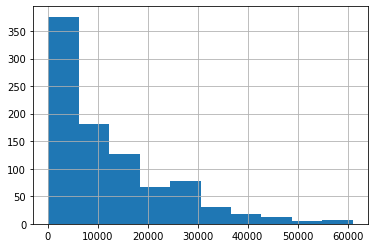

In [37]:
# Turns out that the average population in the dataset is less than 10,000
ne_pops.population.hist()

In [38]:
# I just have to check my homestate of Vermont
ne_pops.loc[(ne_pops['State'] == 'VT')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
249,5641,Barre,VT,Barre,Washington,86600.0,86100.0,85700.0,85300.0,84900.0,...,170100,172100,173200,172700,171400,169500,167900,166900,166200,17169
256,5478,Saint Albans,VT,Burlington,Franklin,102800.0,102300.0,101900.0,101400.0,101000.0,...,209600,209200,208200,207400,207200,207900,208900,210300,211500,14449
318,5602,Montpelier,VT,Barre,Washington,98500.0,98200.0,97800.0,97500.0,97100.0,...,249200,251900,254000,254700,253100,249400,246400,244900,243500,11916
466,5488,Swanton,VT,Burlington,Franklin,104200.0,103700.0,103200.0,102700.0,102200.0,...,193600,192800,192200,192200,192600,193000,193700,194500,195300,7690
557,5676,Waterbury,VT,Barre,Washington,85100.0,84900.0,84800.0,84600.0,84400.0,...,255700,259000,261900,262900,261300,258100,255400,253200,251300,4984
591,5450,Enosburg Falls,VT,Burlington,Franklin,37500.0,37400.0,37400.0,37400.0,37400.0,...,166000,165500,165400,165700,166200,167000,167300,167200,167300,4977
608,5663,Northfield,VT,Barre,Washington,91900.0,91600.0,91300.0,90900.0,90700.0,...,173600,175400,177400,178200,177400,175700,174100,173300,172900,6773
615,5454,Fairfax,VT,Burlington,Franklin,132900.0,132000.0,131200.0,130300.0,129300.0,...,256900,256500,256100,256400,257200,258100,259300,260600,261800,4447
646,5673,Fayston,VT,Barre,Washington,77500.0,77200.0,76800.0,76400.0,76100.0,...,320400,324700,328400,330700,330000,325700,321200,319700,318800,2574
709,5476,Richford,VT,Burlington,Franklin,52400.0,52000.0,51600.0,51200.0,50800.0,...,105800,104300,103300,102600,101800,102300,104400,106100,107200,3183


### Look at Villages

In [39]:
# Villages around 12,000 people
ne_villages = ne_pops.loc[(ne_pops['population'] > 10000) & (ne_pops['population'] < 16000)]
ne_villages.head() 

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
198,2649,Mashpee,MA,Cape Cod,Barnstable,133000.0,132900.0,132700.0,132400.0,132100.0,...,401100,404500,407100,410900,414000,415100,417600,422400,425600,14006
203,3246,Laconia,NH,Laconia,Belknap,84800.0,84300.0,83900.0,83500.0,83200.0,...,179500,180700,182100,183800,185900,187800,189600,192000,194300,15963
217,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,429900,430300,431400,433000,434500,435400,437100,442200,447900,14184
218,3842,Hampton,NH,Boston,Rockingham,135400.0,135600.0,135900.0,136300.0,136800.0,...,379500,382000,384700,387100,389100,390600,391800,394600,398100,15345
220,2601,Barnstable,MA,Cape Cod,Barnstable,95000.0,94800.0,94600.0,94400.0,94200.0,...,278100,280600,282700,285300,287700,289200,292900,299800,305300,14089


In [40]:
# There are still a lot to got through!
ne_villages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 198 to 475
Columns: 271 entries, Zipcode to population
dtypes: float64(219), int64(48), object(4)
memory usage: 272.0+ KB


In [41]:
# Gotta narrow this down
ne_villages.State.value_counts()

MA    78
CT    19
NH    18
RI     7
ME     4
VT     2
Name: State, dtype: int64

In [42]:
# Thin out Mass
ne_villages.drop(ne_villages[(ne_villages.State == "MA") & 
                             (ne_villages.population > 14000)].index,
                 inplace=True)
# No Boston Suburbs!
ne_villages.drop(ne_villages[ne_villages.Metro == "Boston"].index, inplace=True)
# No Fall River!
ne_villages.drop(ne_villages[ne_villages.CountyName == "Bristol"].index, inplace=True)
# No Cape Cod!
ne_villages.drop(ne_villages[ne_villages.Metro == "Cape Cod"].index, inplace=True)
# No Springfield!
ne_villages.drop(ne_villages[ne_villages.City == "Springfield"].index, inplace=True)
# No Worcester Suburbs!
ne_villages.drop(ne_villages[ne_villages.CountyName == "Worcester"].index, inplace=True)
# Get down to two
ne_villages.drop(ne_villages[ne_villages.City == "Agawam"].index, inplace=True)
print(ne_villages.State.value_counts())
ne_villages.loc[(ne_villages['State'] == 'MA')]

CT    19
NH    13
RI     6
ME     4
VT     2
MA     2
Name: State, dtype: int64


,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
365,1062,Northampton,MA,Springfield,Hampshire,127000.0,126200.0,125300.0,124400.0,123500.0,...,274600,276700,278800,280900,282800,284600,285200,282600,279500,11150
371,1082,Ware,MA,Springfield,Hampshire,105300.0,104800.0,104100.0,103500.0,103000.0,...,174600,175400,176500,178000,179400,181100,182500,183300,183800,10322


In [43]:
# Thin out Connetticut
ne_villages.loc[(ne_villages['State'] == 'CT')]
# Thin out CT - Don't want to live in the capital!
ne_villages.drop(ne_villages[(ne_villages.Metro == "Hartford")].index, 
                 inplace=True)
# Who wants to live near 'Yale University'!
ne_villages.drop(ne_villages[ne_villages.Metro == "New Haven"].index, inplace=True)
# Another big suburb!
ne_villages.drop(ne_villages[ne_villages.CountyName == "Fairfield"].index, inplace=True)
# Too close to NYC!
ne_villages.drop(ne_villages[ne_villages.City == "Watertown"].index, inplace=True)
# Get down to two
ne_villages.drop(ne_villages[(ne_villages.State == "CT") & 
                             (ne_villages.population > 12500)].index, inplace=True)
print(ne_villages.State.value_counts())
ne_villages.loc[(ne_villages['State'] == 'CT')]

NH    13
RI     6
ME     4
VT     2
CT     2
MA     2
Name: State, dtype: int64


,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
360,6098,Winsted,CT,Torrington,Litchfield,108700.0,108600.0,108500.0,108300.0,108100.0,...,160000,160700,161300,162600,163900,164800,164800,164300,164400,12426
403,6382,Montville,CT,New London,New London,112800.0,112800.0,112800.0,112800.0,112800.0,...,179300,180600,181600,182400,182400,182600,183300,183900,183700,11947


In [44]:
# Thin out New Hampshire
# Who wants to live near Manchester!
ne_villages.drop(ne_villages[ne_villages.Metro == "Manchester"].index, inplace=True)
# Who wants to live near the capitol!
ne_villages.drop(ne_villages[ne_villages.Metro == "Concord"].index, inplace=True)
# Get down to two
ne_villages.drop(ne_villages[(ne_villages.State == "NH") & 
                             (ne_villages.population > 14000)].index, inplace=True)
print(ne_villages.State.value_counts())
ne_villages.loc[(ne_villages['State'] == 'NH')]

RI    6
ME    4
VT    2
NH    2
CT    2
MA    2
Name: State, dtype: int64


,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
385,3570,Berlin,NH,Berlin,Coos,47600.0,47700.0,47900.0,48000.0,48100.0,...,70400,70800,71000,70800,70200,70000,69900,69100,67500,10051
475,3755,Hanover,NH,Claremont,Grafton,210000.0,209500.0,208900.0,208400.0,208000.0,...,636800,641200,647700,650600,650100,650700,653700,656400,655900,10538


In [45]:
# Thin out Rhode Island
# No Suburbs of Providence!
ne_villages.drop(ne_villages[(ne_villages.City == "Cranston") | 
                             (ne_villages.City == "North Providence")].index,
                 inplace=True)
# Who wants to live near the capitol!
ne_villages.drop(ne_villages[ne_villages.CountyName == "Providence"].index, 
                 inplace=True)
print(ne_villages.State.value_counts())
ne_villages.loc[(ne_villages['State'] == 'RI')]

ME    4
VT    2
NH    2
RI    2
CT    2
MA    2
Name: State, dtype: int64


,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
217,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,429900,430300,431400,433000,434500,435400,437100,442200,447900,14184
234,2878,Tiverton,RI,Providence,Newport,122900.0,122200.0,121600.0,120900.0,120300.0,...,249600,250400,251700,252500,254200,257900,262700,267300,270000,15780


In [46]:
# Thin out Maine
# Get down to two
ne_villages.drop(ne_villages[(ne_villages.City == "Gardiner") | 
                             (ne_villages.City == "Kennebunk")].index, inplace=True)
print(ne_villages.State.value_counts())
ne_villages.loc[(ne_villages['State'] == 'ME')]

VT    2
NH    2
RI    2
ME    2
CT    2
MA    2
Name: State, dtype: int64


,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
330,4530,Bath,ME,Portland,Sagadahoc,NaN,NaN,NaN,NaN,NaN,...,185800,186800,188400,191200,193800,195100,195900,197100,198200,10818
354,4105,Falmouth,ME,Portland,Cumberland,174100.0,174300.0,174400.0,174500.0,174400.0,...,449900,451100,454300,460500,465200,467000,470000,473100,472500,11158


## Getting Latitude and Longitude for folium map

In [47]:
# Zip code info from zipcode database
# https://www.unitedstateszipcodes.org/zip-code-database/
latlong_codes = pd.read_csv("zip_code_database.csv")
latlong_codes.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
0,501,UNIQUE,0,Holtsville,NaN,I R S Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Irs Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


In [48]:
# I just want the zipcodes and the lat/lon
latlong_codes = latlong_codes.filter(['zip','latitude', 'longitude'], axis=1)
latlong_codes.head()

,zip,latitude,longitude
0,501,40.81,-73.04
1,544,40.81,-73.04
2,601,18.16,-66.72
3,602,18.38,-67.18
4,603,18.43,-67.15


In [49]:
# zip seems confusing
latlong_codes.rename(columns={"zip": "zip_codes"}, inplace=True)
latlong_codes.head()

,zip_codes,latitude,longitude
0,501,40.81,-73.04
1,544,40.81,-73.04
2,601,18.16,-66.72
3,602,18.38,-67.18
4,603,18.43,-67.15


In [50]:
# Get rid of short codes and anything not in New England
ne_codes = latlong_codes[(latlong_codes.zip_codes > 999) & (latlong_codes.zip_codes < 6999)]
ne_codes.describe()

,zip_codes,latitude,longitude
count,2314.000000,2314.000000,2314.000000
mean,4017.314175,42.953133,-71.467143
std,1742.809270,1.265165,1.377289
min,1001.000000,41.020000,-73.660000
25%,2478.250000,41.900000,-72.580000
50%,4090.500000,42.590000,-71.580000
75%,5601.750000,43.970000,-70.800000
max,6928.000000,47.450000,-67.010000


### Merge Location and Villages

In [51]:
# Merge the lat and lon with my first NE dataframe
ne_village_map = ne_villages.merge(ne_codes, left_on='Zipcode', right_on='zip_codes')
ne_village_map.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population,zip_codes,latitude,longitude
0,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,433000,434500,435400,437100,442200,447900,14184,2882,41.39,-71.48
1,2878,Tiverton,RI,Providence,Newport,122900.0,122200.0,121600.0,120900.0,120300.0,...,252500,254200,257900,262700,267300,270000,15780,2878,41.65,-71.20
2,5478,Saint Albans,VT,Burlington,Franklin,102800.0,102300.0,101900.0,101400.0,101000.0,...,207400,207200,207900,208900,210300,211500,14449,5478,44.81,-73.08
3,5602,Montpelier,VT,Barre,Washington,98500.0,98200.0,97800.0,97500.0,97100.0,...,254700,253100,249400,246400,244900,243500,11916,5602,44.26,-72.57
4,4530,Bath,ME,Portland,Sagadahoc,NaN,NaN,NaN,NaN,NaN,...,191200,193800,195100,195900,197100,198200,10818,4530,43.93,-69.83


In [52]:
# Drop the one zipcode column
ne_village_map.drop('zip_codes', axis=1, inplace=True)

In [53]:
ne_village_map

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population,latitude,longitude
0,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,431400,433000,434500,435400,437100,442200,447900,14184,41.39,-71.48
1,2878,Tiverton,RI,Providence,Newport,122900.0,122200.0,121600.0,120900.0,120300.0,...,251700,252500,254200,257900,262700,267300,270000,15780,41.65,-71.20
2,5478,Saint Albans,VT,Burlington,Franklin,102800.0,102300.0,101900.0,101400.0,101000.0,...,208200,207400,207200,207900,208900,210300,211500,14449,44.81,-73.08
3,5602,Montpelier,VT,Barre,Washington,98500.0,98200.0,97800.0,97500.0,97100.0,...,254000,254700,253100,249400,246400,244900,243500,11916,44.26,-72.57
4,4530,Bath,ME,Portland,Sagadahoc,NaN,NaN,NaN,NaN,NaN,...,188400,191200,193800,195100,195900,197100,198200,10818,43.93,-69.83
5,4105,Falmouth,ME,Portland,Cumberland,174100.0,174300.0,174400.0,174500.0,174400.0,...,454300,460500,465200,467000,470000,473100,472500,11158,43.72,-70.24
6,6098,Winsted,CT,Torrington,Litchfield,108700.0,108600.0,108500.0,108300.0,108100.0,...,161300,162600,163900,164800,164800,164300,164400,12426,41.92,-73.06
7,1062,Northampton,MA,Springfield,Hampshire,127000.0,126200.0,125300.0,124400.0,123500.0,...,278800,280900,282800,284600,285200,282600,279500,11150,42.32,-72.67
8,1082,Ware,MA,Springfield,Hampshire,105300.0,104800.0,104100.0,103500.0,103000.0,...,176500,178000,179400,181100,182500,183300,183800,10322,42.25,-72.24
9,3570,Berlin,NH,Berlin,Coos,47600.0,47700.0,47900.0,48000.0,48100.0,...,71000,70800,70200,70000,69900,69100,67500,10051,44.48,-71.25


In [54]:
# Find out where these zip codes are located
import folium
NE = folium.Map([42.9956, -71.4548],zoom_start=7, min_zoom=7, max_zoom=7, 
                width='50%')
#location
for lat,lon in zip(ne_village_map['latitude'],ne_village_map['longitude']):
     folium.CircleMarker([lat, lon], radius=3).add_to(NE)
NE

### Looking at price changes

In [55]:
# New df for 1 year, 3 year, 5 year averages

In [56]:
# Create a new df for top 12 zip codes and averages
ne_vil_averages = ne_villages[['Zipcode', 'State']].copy()

In [57]:
# Mean of 2017 to 2018 (from May to April - since Spring is the beginning of
# most Real Estate seasons!)

In [58]:
mean_2014 = ne_villages.loc[: , "2013-05":"2014-04"]
ne_vil_averages['2014'] = mean_2014.mean(axis=1)

In [59]:
mean_2015 = ne_villages.loc[: , "2014-05":"2015-04"]
ne_vil_averages['2015'] = mean_2015.mean(axis=1)

In [60]:
mean_2016 = ne_villages.loc[: , "2015-05":"2016-04"]
ne_vil_averages['2016'] = mean_2016.mean(axis=1)

In [61]:
mean_2017 = ne_villages.loc[: , "2016-05":"2017-04"]
ne_vil_averages['2017'] = mean_2017.mean(axis=1)

In [62]:
mean_2018 = ne_villages.loc[: , "2017-05":"2018-04"]
ne_vil_averages['2018'] = mean_2018.mean(axis=1)

In [63]:
# Look at each of the five years above
ne_vil_averages

,Zipcode,State,2014,2015,2016,2017,2018
217,2882,RI,361550.000000,369075.000000,377183.333333,412908.333333,433991.666667
234,2878,RI,234783.333333,236408.333333,230975.000000,243091.666667,255266.666667
256,5478,VT,190025.000000,192116.666667,197858.333333,203041.666667,208683.333333
318,5602,VT,223416.666667,229041.666667,231633.333333,234275.000000,248841.666667
330,4530,ME,162125.000000,168841.666667,172550.000000,178575.000000,190158.333333
354,4105,ME,359308.333333,394225.000000,406783.333333,429500.000000,457558.333333
360,6098,CT,152158.333333,148158.333333,140658.333333,156533.333333,162066.666667
365,1062,MA,244883.333333,242808.333333,246858.333333,256316.666667,278175.000000
371,1082,MA,156116.666667,152266.666667,159408.333333,171450.000000,178300.000000
385,3570,NH,67316.666667,67725.000000,67408.333333,66958.333333,69866.666667


In [64]:
# Compute short term averages 1 year, 3 year, 5 year as a percent
ne_vil_averages['5_year'] = ne_vil_averages.apply(lambda row: (row['2018'] - row['2014']) / row['2014'] , axis = 1) 
ne_vil_averages['3_year'] = ne_vil_averages.apply(lambda row: (row['2018'] - row['2016']) / row['2016'], axis = 1) 
ne_vil_averages['1_year'] = ne_vil_averages.apply(lambda row: (row['2018'] - row['2017']) / row['2017'], axis = 1) 

In [65]:
# Top twelve with percentages
ne_vil_averages

,Zipcode,State,2014,2015,2016,2017,2018,5_year,3_year,1_year
217,2882,RI,361550.000000,369075.000000,377183.333333,412908.333333,433991.666667,0.200364,0.150612,0.051061
234,2878,RI,234783.333333,236408.333333,230975.000000,243091.666667,255266.666667,0.087244,0.105170,0.050084
256,5478,VT,190025.000000,192116.666667,197858.333333,203041.666667,208683.333333,0.098189,0.054711,0.027786
318,5602,VT,223416.666667,229041.666667,231633.333333,234275.000000,248841.666667,0.113801,0.074291,0.062178
330,4530,ME,162125.000000,168841.666667,172550.000000,178575.000000,190158.333333,0.172912,0.102048,0.064865
354,4105,ME,359308.333333,394225.000000,406783.333333,429500.000000,457558.333333,0.273442,0.124821,0.065328
360,6098,CT,152158.333333,148158.333333,140658.333333,156533.333333,162066.666667,0.065119,0.152201,0.035349
365,1062,MA,244883.333333,242808.333333,246858.333333,256316.666667,278175.000000,0.135949,0.126861,0.085279
371,1082,MA,156116.666667,152266.666667,159408.333333,171450.000000,178300.000000,0.142095,0.118511,0.039953
385,3570,NH,67316.666667,67725.000000,67408.333333,66958.333333,69866.666667,0.037881,0.036469,0.043435


In [66]:
ne_vil_averages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 217 to 475
Data columns (total 10 columns):
Zipcode    12 non-null int64
State      12 non-null object
2014       12 non-null float64
2015       12 non-null float64
2016       12 non-null float64
2017       12 non-null float64
2018       12 non-null float64
5_year     12 non-null float64
3_year     12 non-null float64
1_year     12 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.0+ KB


In [67]:
# Create a copy without the index
ne_aves = ne_vil_averages.copy()

In [68]:
# Use Zipcodes as index
ne_aves = ne_aves.set_index('Zipcode')

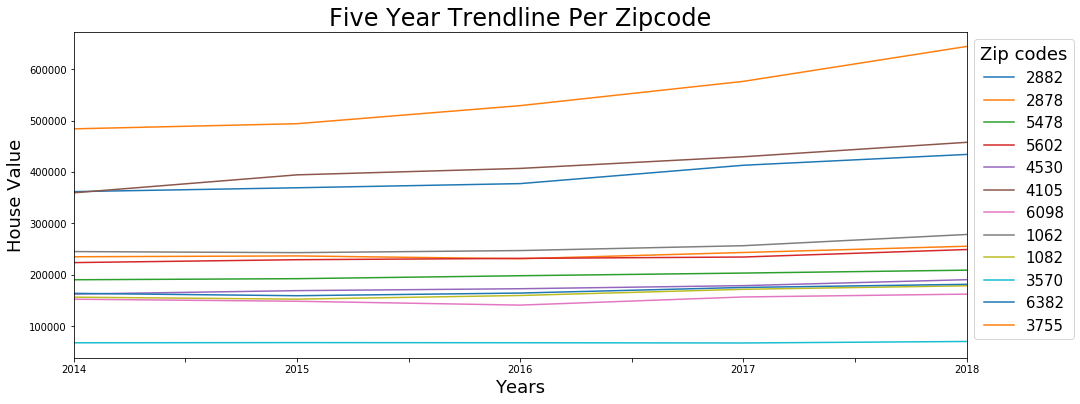

In [69]:
# Line graph showing five year trends for each zipcode
for index, row in ne_aves.iterrows():
    row[1:6].plot(kind = 'line', figsize=(16,6))
plt.title('Five Year Trendline Per Zipcode', size=24)
plt.xlabel('Years', size=18)
plt.ylabel('House Value', size=18)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, title='Zip codes', 
          title_fontsize=18, fontsize=15)

In the last five years most of the zip codes remained fairly constant with a some of the more expensive zip code markets increasing slightly (except for 03755, at the top, which showed a larger increase in the last five years).

Text(0, 0.5, 'Percantage')

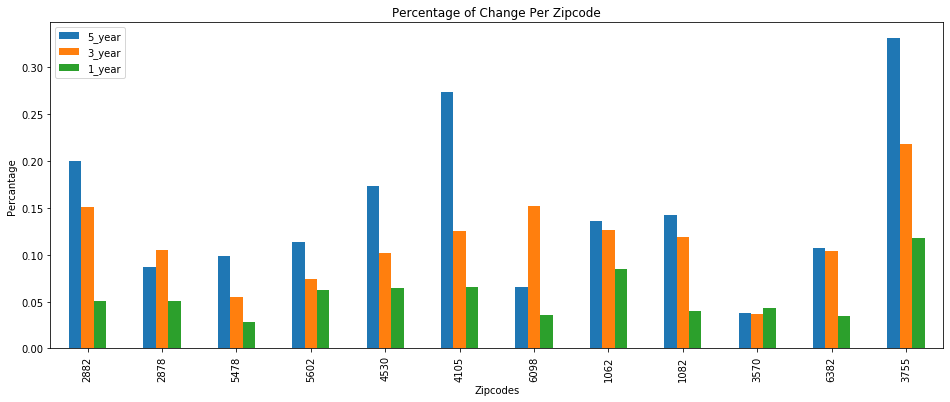

In [70]:
# Bar graph showing '5 year', '3 year', and  '1 year' percentage changes
ne_vil_averages.plot(x="Zipcode", y=['5_year', '3_year', '1_year'], kind="bar", figsize=(16,6))
plt.title('Percentage of Change Per Zipcode')
plt.xlabel('Zipcodes')
plt.ylabel('Percantage')

According to the bar graph and percentages - top six zips are:
( 1062, 2882, 3755, 4105, 5602, 6382 ) based on highest five year return.

Text(0, 0.5, 'Percantage')

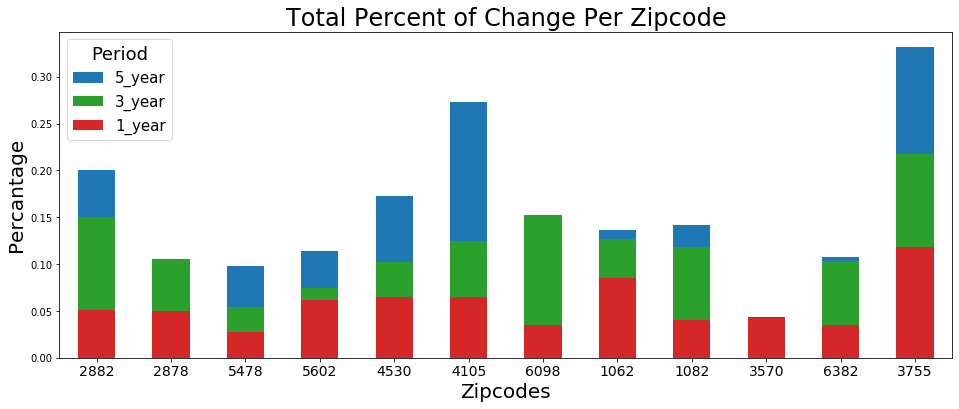

In [106]:
# I wanted to cross reference this with a stacked bar to see total returns.
# Stacked bar graph showing total '5 year', '3 year', and  '1 year' percentage changes
ax = ne_vil_averages.plot(x="Zipcode", y='5_year', kind="bar", figsize=(16,6))
ne_vil_averages.plot(x="Zipcode", y='3_year', kind="bar", ax=ax, color="C2")
ne_vil_averages.plot(x="Zipcode", y='1_year', kind="bar", ax=ax, color="C3")
plt.title('Total Percent of Change Per Zipcode', size=24)
plt.legend(loc='upper left', title='Period',  title_fontsize=18, fontsize=15)
plt.xlabel('Zipcodes', size=20)
plt.xticks(rotation='horizontal', size=14)
plt.ylabel('Percantage', size=20)

Best stacked growth (1+3+5 year) - 1082, 2882, 3755, 4105, 5602, 6382. The only change being one zip code which showed better five year growth but had more significant growth in the last year (which seems more important).

## My Top Six!

In [74]:
# Get my top six
ne_six = ne_vil_averages.copy()

In [75]:
# Drop the other six
ne_six.drop(ne_six[(ne_six.Zipcode == 1062) |
                  (ne_six.Zipcode == 2878) |
                  (ne_six.Zipcode == 3570) |
                  (ne_six.Zipcode == 4530) |
                  (ne_six.Zipcode == 5478) |
                  (ne_six.Zipcode == 6098)].index, inplace=True)

In [76]:
# Review top six
ne_six

,Zipcode,State,2014,2015,2016,2017,2018,5_year,3_year,1_year
217,2882,RI,361550.000000,369075.000000,377183.333333,412908.333333,433991.666667,0.200364,0.150612,0.051061
318,5602,VT,223416.666667,229041.666667,231633.333333,234275.000000,248841.666667,0.113801,0.074291,0.062178
354,4105,ME,359308.333333,394225.000000,406783.333333,429500.000000,457558.333333,0.273442,0.124821,0.065328
371,1082,MA,156116.666667,152266.666667,159408.333333,171450.000000,178300.000000,0.142095,0.118511,0.039953
403,6382,CT,163541.666667,158933.333333,164133.333333,175050.000000,181150.000000,0.107669,0.103676,0.034847
475,3755,NH,483800.000000,493791.666667,528975.000000,576225.000000,644158.333333,0.331456,0.217748,0.117894


Text(0, 0.5, 'Percantage')

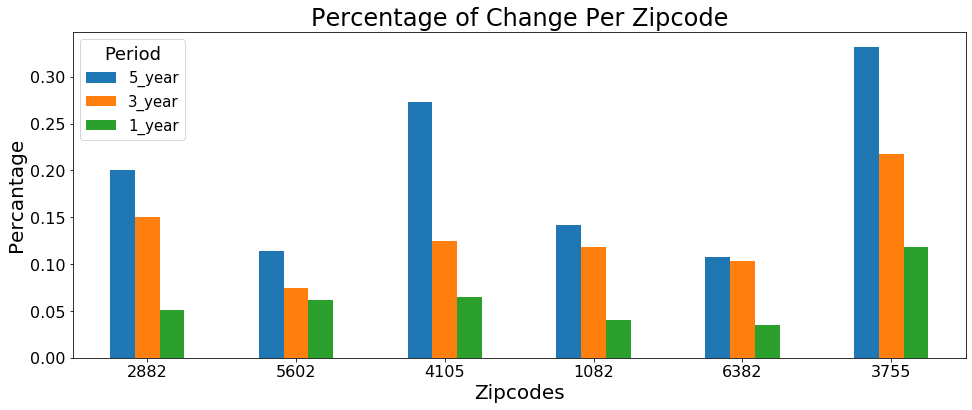

In [77]:
# Bar graph showing '5 year', '3 year', and  '1 year' percentage changes for just top six
ne_six.plot(x="Zipcode", y=['5_year', '3_year', '1_year'], kind="bar", 
            figsize=(16,6), fontsize=16)
plt.title('Percentage of Change Per Zipcode', size=24)
plt.legend(loc='upper left', title='Period',  title_fontsize=18, fontsize=15)
plt.xlabel('Zipcodes', size=20)
plt.xticks(rotation='horizontal')
plt.ylabel('Percantage', size=20)

# Time Series Model

## Back to the original data

In [78]:
# I need only the six rows in a new df
final_six = ne_villages.loc[(ne_villages['Zipcode'] == 1082) + 
                                (ne_villages['Zipcode'] == 2882) + 
                                (ne_villages['Zipcode'] == 3755) + 
                                (ne_villages['Zipcode'] == 4105) + 
                                (ne_villages['Zipcode'] == 5602) + 
                                (ne_villages['Zipcode'] == 6382)].sort_values(by='Zipcode')
final_six

/Users/whipxach/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
371,1082,Ware,MA,Springfield,Hampshire,105300.0,104800.0,104100.0,103500.0,103000.0,...,174600,175400,176500,178000,179400,181100,182500,183300,183800,10322
217,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,429900,430300,431400,433000,434500,435400,437100,442200,447900,14184
475,3755,Hanover,NH,Claremont,Grafton,210000.0,209500.0,208900.0,208400.0,208000.0,...,636800,641200,647700,650600,650100,650700,653700,656400,655900,10538
354,4105,Falmouth,ME,Portland,Cumberland,174100.0,174300.0,174400.0,174500.0,174400.0,...,449900,451100,454300,460500,465200,467000,470000,473100,472500,11158
318,5602,Montpelier,VT,Barre,Washington,98500.0,98200.0,97800.0,97500.0,97100.0,...,249200,251900,254000,254700,253100,249400,246400,244900,243500,11916
403,6382,Montville,CT,New London,New London,112800.0,112800.0,112800.0,112800.0,112800.0,...,179300,180600,181600,182400,182400,182600,183300,183900,183700,11947


In [79]:
# Drop unnecessary columns
final_six = final_six.drop(['City','State','Metro','CountyName','population'],
                           axis=1)
final_six

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
371,1082,105300.0,104800.0,104100.0,103500.0,103000.0,102500.0,102000.0,101600.0,101300.0,...,174200,174600,175400,176500,178000,179400,181100,182500,183300,183800
217,2882,145000.0,144700.0,144400.0,144100.0,143800.0,143500.0,143400.0,143100.0,143000.0,...,429600,429900,430300,431400,433000,434500,435400,437100,442200,447900
475,3755,210000.0,209500.0,208900.0,208400.0,208000.0,207800.0,207700.0,207600.0,207600.0,...,634100,636800,641200,647700,650600,650100,650700,653700,656400,655900
354,4105,174100.0,174300.0,174400.0,174500.0,174400.0,174200.0,173900.0,173500.0,173200.0,...,447200,449900,451100,454300,460500,465200,467000,470000,473100,472500
318,5602,98500.0,98200.0,97800.0,97500.0,97100.0,96800.0,96400.0,96200.0,96100.0,...,247400,249200,251900,254000,254700,253100,249400,246400,244900,243500
403,6382,112800.0,112800.0,112800.0,112800.0,112800.0,112800.0,112800.0,112700.0,112800.0,...,178400,179300,180600,181600,182400,182400,182600,183300,183900,183700


In [80]:
# Breaking them down one by one, since I need each zip code in a seperate df.

In [81]:
MA_1082 = ne_villages.loc[(ne_villages['Zipcode'] == 1082)]

In [82]:
MA_1082

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
371,1082,Ware,MA,Springfield,Hampshire,105300.0,104800.0,104100.0,103500.0,103000.0,...,174600,175400,176500,178000,179400,181100,182500,183300,183800,10322


In [83]:
RI_2882 = ne_villages.loc[(ne_villages['Zipcode'] == 2882)]

In [84]:
RI_2882

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
217,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,429900,430300,431400,433000,434500,435400,437100,442200,447900,14184


In [85]:
NH_3755 = ne_villages.loc[(ne_villages['Zipcode'] == 3755)]

In [86]:
NH_3755

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
475,3755,Hanover,NH,Claremont,Grafton,210000.0,209500.0,208900.0,208400.0,208000.0,...,636800,641200,647700,650600,650100,650700,653700,656400,655900,10538


In [87]:
ME_4105 = ne_villages.loc[(ne_villages['Zipcode'] == 4105)]

In [88]:
VT_5602 = ne_villages.loc[(ne_villages['Zipcode'] == 5602)]

In [89]:
CT_6382 = ne_villages.loc[(ne_villages['Zipcode'] == 6382)]

## Functions

Below are the functions that I will use:

### Reshape from Wide to Long Format

In [90]:
# Melting the data to long format, grouping by time and value, filling NaN's
def melt_data(df):
    melted = pd.melt(df, id_vars=['Zipcode', 'City', 'State', 'Metro', 
                                  'CountyName', 'population'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted = melted.groupby('time').aggregate({'value':'mean'})
    melted = melted['value'].resample('MS').mean()
    melted = melted.fillna(melted.bfill())
    return melted

### Auto-Correlation

In [91]:
# This function will get me the correlation graphs
def corr_graphs(melted):
    model =' '
    color = 'g'
    fig, ax = plt.subplots(figsize=(12,3))
    plot_acf(melted, ax=ax, lags=22,  color= color, title=model + 
             ' Autocorrelation');
    fig, ax = plt.subplots(figsize=(12,3))
    plot_pacf(melted, ax=ax, lags=22, color=color, title=model +
              ' Partial Autocorrelation');

### SARIMA Model

In [92]:
# This is the function that will choose the best 'pdq' and run the model
import warnings
warnings.filterwarnings('ignore')

def run_model(melted):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)
    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(melted, order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue
    # Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    print("Minimum AIC Value and Optimal Params ", '\n', 
          ans_df.loc[ans_df['aic'].idxmin()], '\n')

    # Plug the optimal parameter values into a new SARIMAX model
    SARIMA_MODEL = sm.tsa.statespace.SARIMAX(melted, 
                                             order=ans_df.loc[ans_df['aic'].idxmin()]['pdq'],
                                             seasonal_order=ans_df.loc[ans_df['aic'].
                                                                       idxmin()]['pdqs'], 
                                             enforce_stationarity=False, 
                                             enforce_invertibility=False)
    # Fit the model and print results
    output = SARIMA_MODEL.fit()
    print("SARIMA Model ", '\n', output.summary().tables[1])
    
    # Call plot_diagnostics() on the results calculated above 
    output.plot_diagnostics(figsize=(12, 6))
    plt.show()
    return output

### Future Predictions

In [93]:
# This function will get the confidence interval for the predictions and graphs
def get_predictions(melted, output):
    # Get predictions starting from 2016-04-01 and calculate confidence intervals
    pred = output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=False)
    pred_conf = pred.conf_int()
    # Plot real vs predicted values along with confidence interval
    rcParams['figure.figsize'] = (12, 3)
    # Plot observed values
    ax = melted['2010':].plot(label='observed')
    # Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)
    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

    # Set axes labels
    ax.set_title('One-Step Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    plt.legend()
    plt.show()

    # Get forecast for future (60 steps = 5 years)
    prediction = output.get_forecast(steps=60)
    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()

    # Plot future predictions with confidence intervals
    ax = melted.plot(label='observed', figsize=(12, 3))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='y', alpha=0.25)
    ax.set_title('Future Predictions', size = 18)
    ax.set_xlabel('Date', size=16)
    ax.set_ylabel('Values', size=16)
    plt.legend(loc='upper left')
    plt.show()
    
    # Get the real and predicted values
    melted_forecasted = pred.predicted_mean
    melted_truth = melted['2016-04-01':]
    
    # Compute the mean square error
    mse = ((melted_forecasted - melted_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)),
          '\n')
    # Compute the root mean square error
    rmse = np.sqrt(mse)
    print('The RMSE of our forecasts is {}'.format(round(rmse, 2), ), '\n')
    
     # Compute the normalized root mean square error using max/min
    nrmse = rmse*100/(pred_conf['upper value'].max() - pred_conf['lower value'].min())
    print('The Max/Min Normalized RMSE is {}'.format(round(nrmse, 2)), '\n')
    
    # Compute the mean_absolute_percentage_error
    mape = np.mean(np.abs((melted_truth - melted_forecasted) / melted_truth))
    print('The Mean Absolute Percentage Error is {}%'.format(round(mape * 100, 2)),'\n')
    
    # Compute average column
    pred_conf['mean value'] = pred_conf.apply(lambda row: (row['lower value'] + 
                                                       row['upper value'])/2, 
                                              axis=1)
    # Add helpful data for analysis
    print('The Current Value is: $', melted[-1],'\n')
    print('The Five Year predictions values are: ', '\n', 
          (round(pred_conf.tail(1), 2)), '\n')
    
    # Plot just prediction
    pred_conf.plot(figsize=(10,2))
    plt.title('Predicted Forecast', size=18)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.xlabel('Years', size=15)
    plt.xticks(rotation='horizontal')
    plt.ylabel('Value', size=15)
    
    # Average change in predicted value
    start_pred = pred_conf['mean value'][0]
    end_pred = pred_conf['mean value'][59]
    change_pred = (end_pred - start_pred)/start_pred
    print('The Five Year average change in value:', (round(change_pred, 4)*100), '%')

## Master Function

In [94]:
# This function will run all of the above functions when an individual zipcode df is entered
def master_function(df):
    melted = melt_data(df)
    corr_graphs(melted)
    output = run_model(melted)
    get_predictions(melted, output)

### Run it for results

Now I will run individually each of the six zip codes into my master function.

#### MA 1082

Minimum AIC Value and Optimal Params  
 pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           3623.56
Name: 59, dtype: object 

SARIMA Model  
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8699      0.023     38.232      0.000       0.825       0.914
ma.L1          0.5417      0.033     16.315      0.000       0.477       0.607
ma.S.L12      -0.7988      0.039    -20.547      0.000      -0.875      -0.723
sigma2      1.588e+05   1.06e+04     15.014      0.000    1.38e+05     1.8e+05


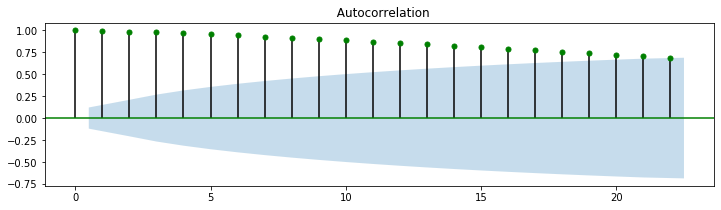

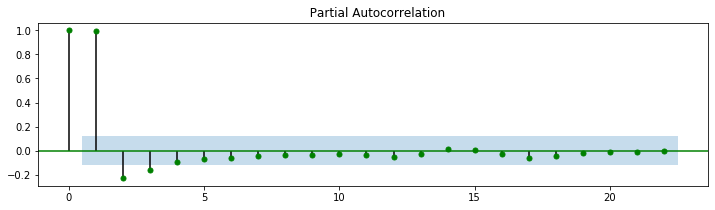

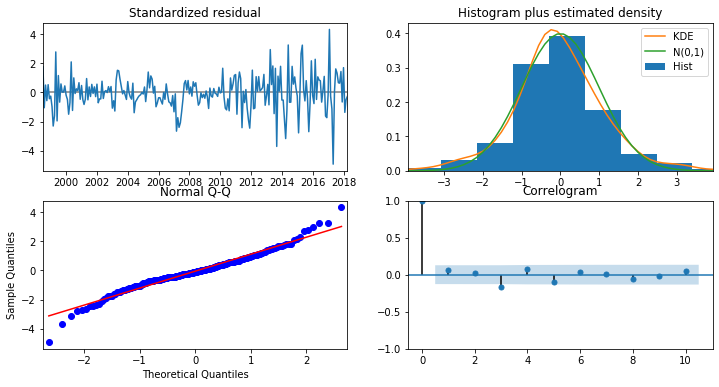

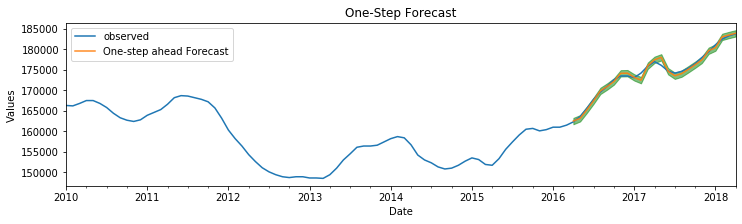

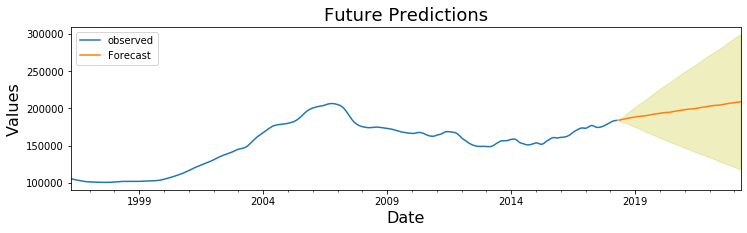

The Mean Squared Error of our forecasts is 425701.77 

The RMSE of our forecasts is 652.46 

The Max/Min Normalized RMSE is 0.36 

The Mean Absolute Percentage Error is 0.27% 

The Current Value is: $ 183800.0 

The Five Year predictions values are:  
             lower value  upper value  mean value
2023-04-01    117775.48    299559.42   208667.45 

The Five Year average change in value: 13.36 %


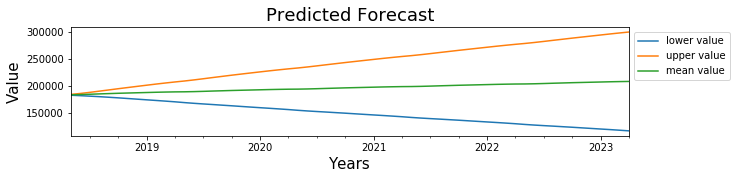

In [95]:
master_function(MA_1082)

#### RI 2882

Minimum AIC Value and Optimal Params  
 pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic            4041.6
Name: 59, dtype: object 

SARIMA Model  
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7316      0.036     20.526      0.000       0.662       0.801
ma.L1          0.7653      0.034     22.763      0.000       0.699       0.831
ma.S.L12      -0.3128      0.030    -10.262      0.000      -0.373      -0.253
sigma2      1.131e+06   8.19e+04     13.807      0.000     9.7e+05    1.29e+06


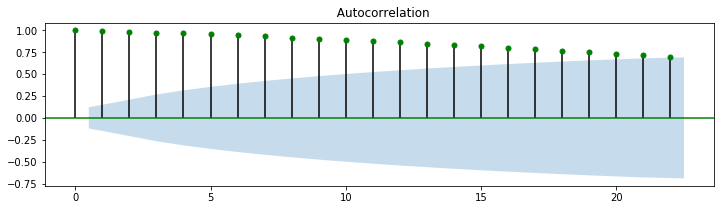

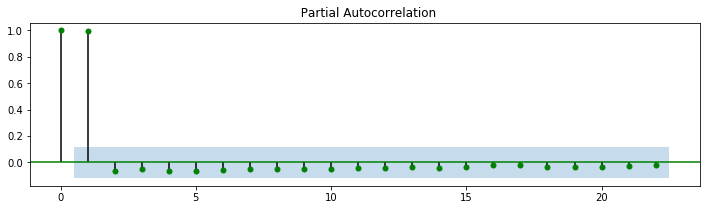

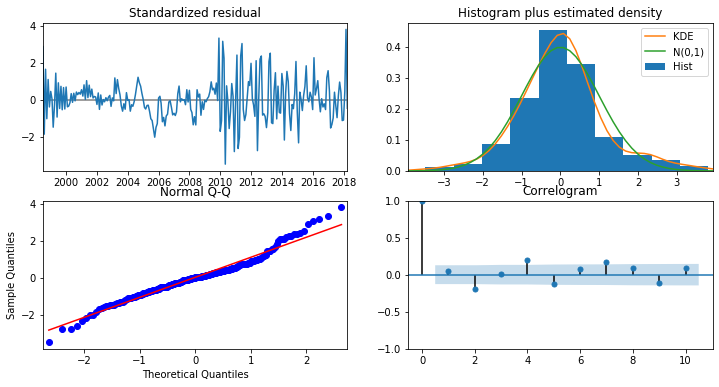

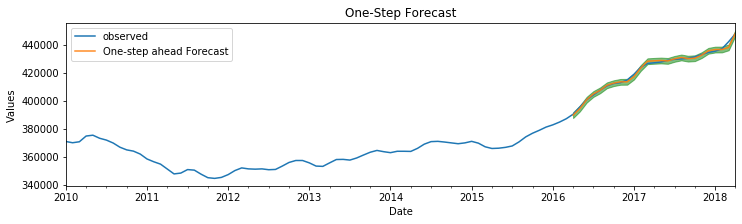

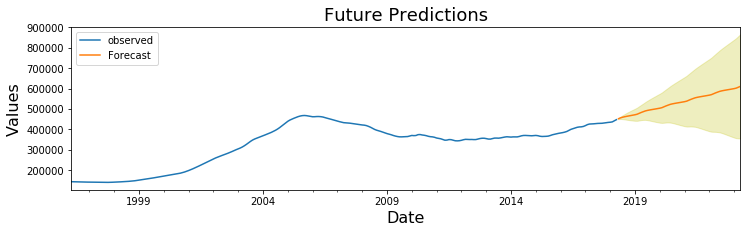

The Mean Squared Error of our forecasts is 1415012.19 

The RMSE of our forecasts is 1189.54 

The Max/Min Normalized RMSE is 0.23 

The Mean Absolute Percentage Error is 0.21% 

The Current Value is: $ 447900.0 

The Five Year predictions values are:  
             lower value  upper value  mean value
2023-04-01    355691.02    865677.64   610684.33 

The Five Year average change in value: 34.93 %


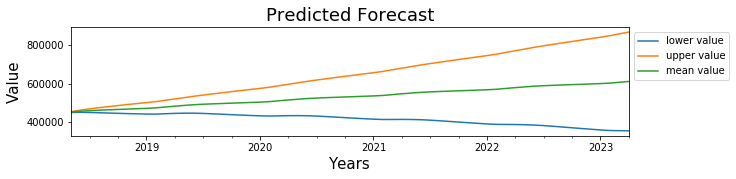

In [97]:
master_function(RI_2882)

#### NH 3755

Minimum AIC Value and Optimal Params  
 pdq         (1, 1, 1)
pdqs    (0, 0, 1, 12)
aic           4339.07
Name: 57, dtype: object 

SARIMA Model  
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8731      0.037     23.315      0.000       0.800       0.946
ma.L1          0.6984      0.044     15.856      0.000       0.612       0.785
ma.S.L12      -0.3234      0.038     -8.418      0.000      -0.399      -0.248
sigma2      2.201e+06   1.48e+05     14.857      0.000    1.91e+06    2.49e+06


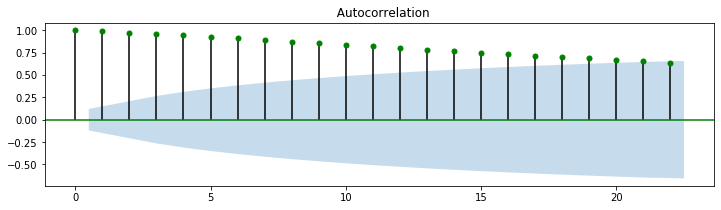

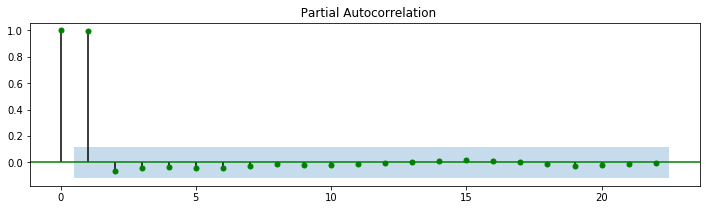

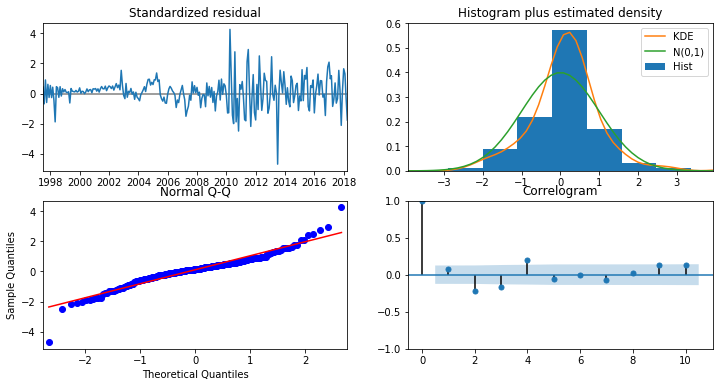

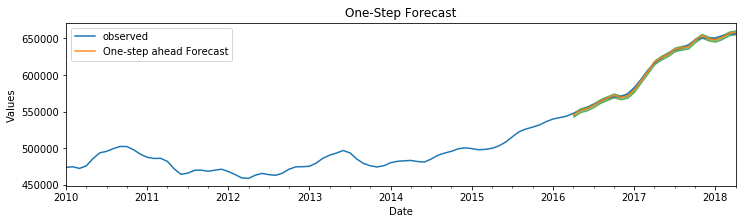

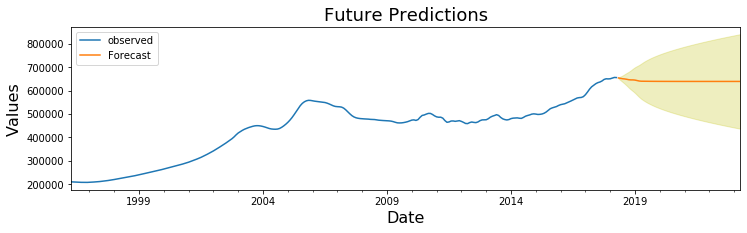

The Mean Squared Error of our forecasts is 2831160.97 

The RMSE of our forecasts is 1682.61 

The Max/Min Normalized RMSE is 0.42 

The Mean Absolute Percentage Error is 0.23% 

The Current Value is: $ 655900.0 

The Five Year predictions values are:  
             lower value  upper value  mean value
2023-04-01    437033.89    841607.45   639320.67 

The Five Year average change in value: -2.26 %


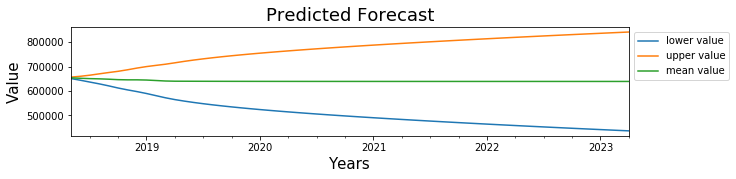

In [98]:
master_function(NH_3755)

#### ME 4105

Minimum AIC Value and Optimal Params  
 pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           3953.83
Name: 63, dtype: object 

SARIMA Model  
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7356      0.028     26.394      0.000       0.681       0.790
ma.L1          0.7359      0.037     19.942      0.000       0.664       0.808
ar.S.L12       0.0927      0.043      2.148      0.032       0.008       0.177
ma.S.L12      -0.4136      0.032    -12.763      0.000      -0.477      -0.350
sigma2      1.013e+06   5.74e+04     17.636      0.000       9e+05    1.13e+06


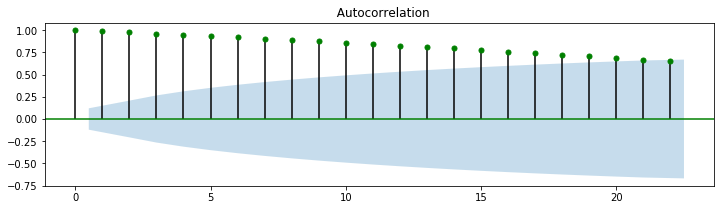

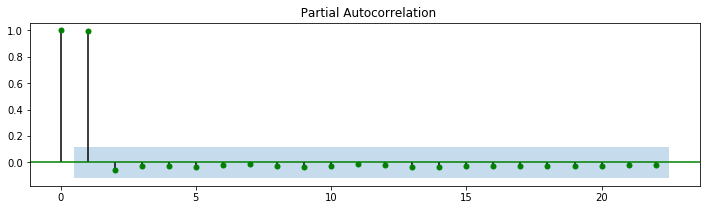

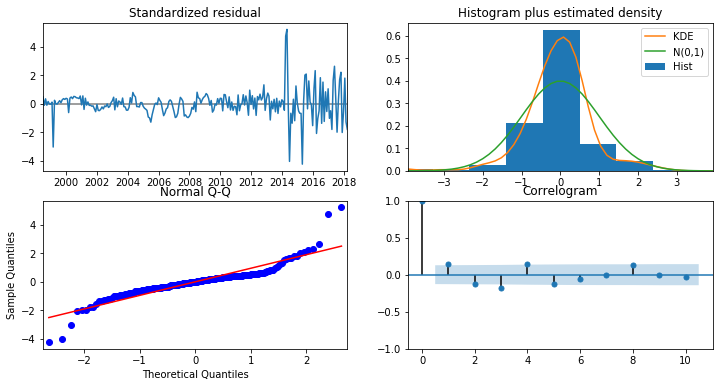

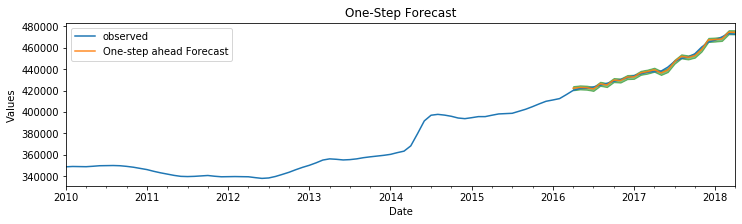

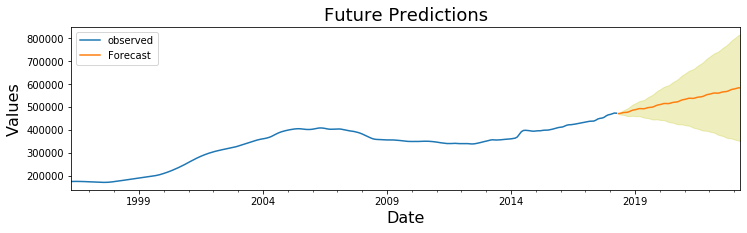

The Mean Squared Error of our forecasts is 2240160.64 

The RMSE of our forecasts is 1496.72 

The Max/Min Normalized RMSE is 0.32 

The Mean Absolute Percentage Error is 0.3% 

The Current Value is: $ 472500.0 

The Five Year predictions values are:  
             lower value  upper value  mean value
2023-04-01    348796.48    817979.55   583388.02 

The Five Year average change in value: 23.880000000000003 %


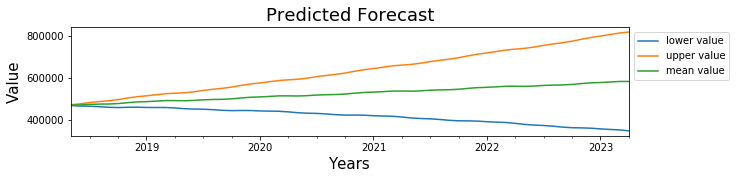

In [99]:
master_function(ME_4105)

#### VT 5602

Minimum AIC Value and Optimal Params  
 pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           3739.86
Name: 59, dtype: object 

SARIMA Model  
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7216      0.031     23.138      0.000       0.660       0.783
ma.L1          0.7105      0.031     23.056      0.000       0.650       0.771
ma.S.L12      -0.7430      0.033    -22.193      0.000      -0.809      -0.677
sigma2      2.611e+05   1.75e+04     14.943      0.000    2.27e+05    2.95e+05


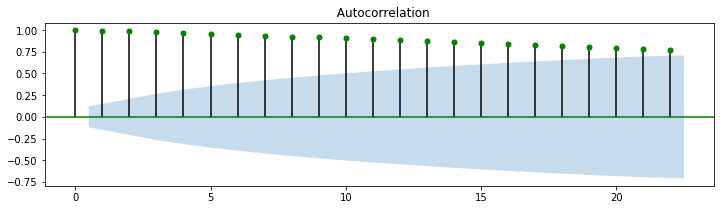

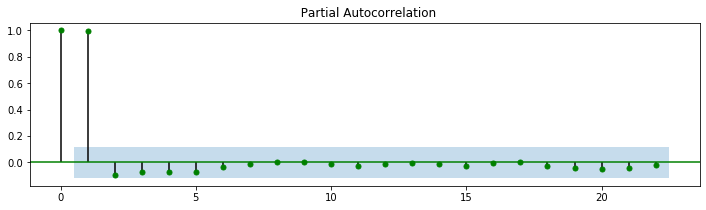

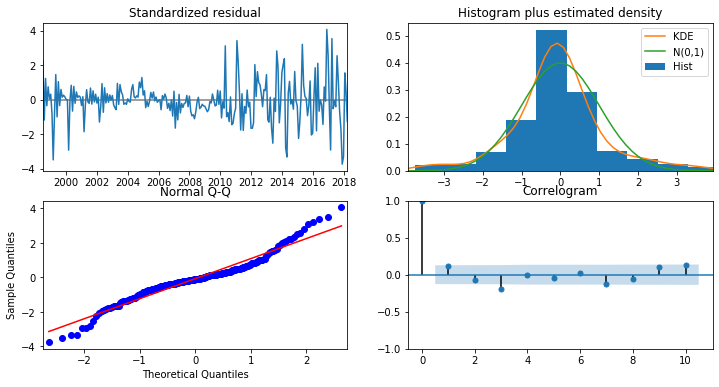

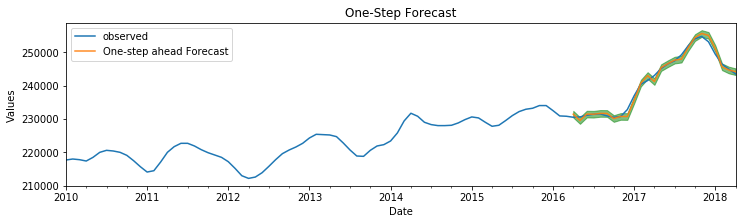

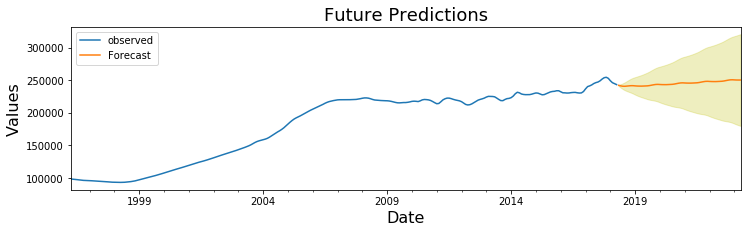

The Mean Squared Error of our forecasts is 1005205.88 

The RMSE of our forecasts is 1002.6 

The Max/Min Normalized RMSE is 0.71 

The Mean Absolute Percentage Error is 0.32% 

The Current Value is: $ 243500.0 

The Five Year predictions values are:  
             lower value  upper value  mean value
2023-04-01    179984.53    320949.13   250466.83 

The Five Year average change in value: 3.37 %


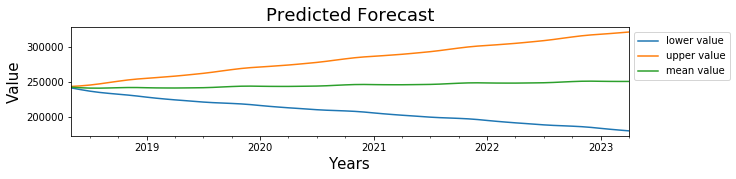

In [100]:
master_function(VT_5602)

#### CT 3682

Minimum AIC Value and Optimal Params  
 pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           3576.24
Name: 63, dtype: object 

SARIMA Model  
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8916      0.030     29.994      0.000       0.833       0.950
ma.L1          0.4575      0.038     11.896      0.000       0.382       0.533
ar.S.L12       0.0870      0.017      5.202      0.000       0.054       0.120
ma.S.L12      -0.9818      0.155     -6.329      0.000      -1.286      -0.678
sigma2      1.504e+05   2.22e+04      6.785      0.000    1.07e+05    1.94e+05


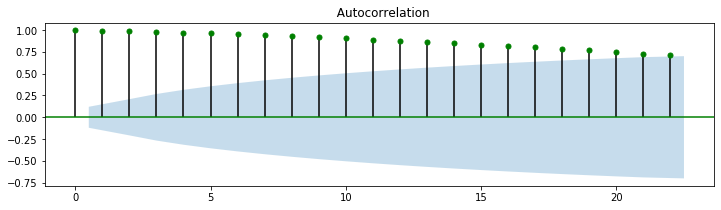

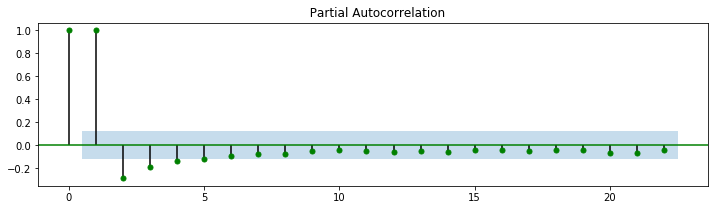

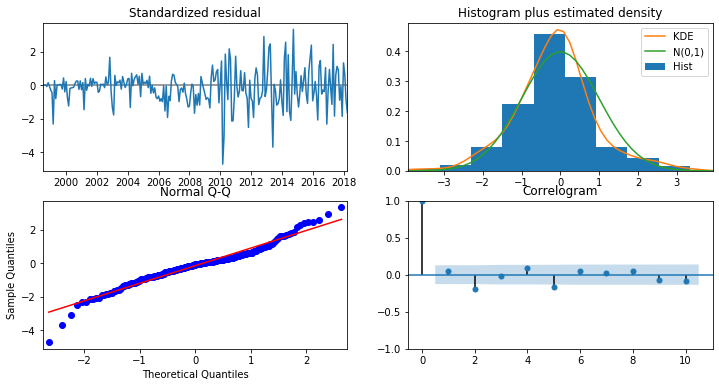

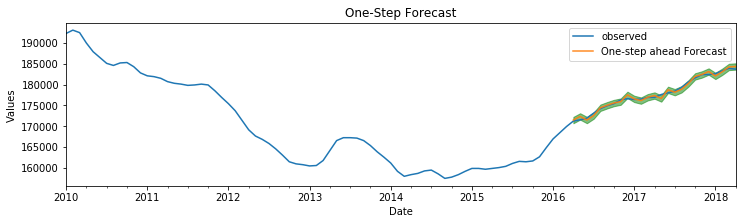

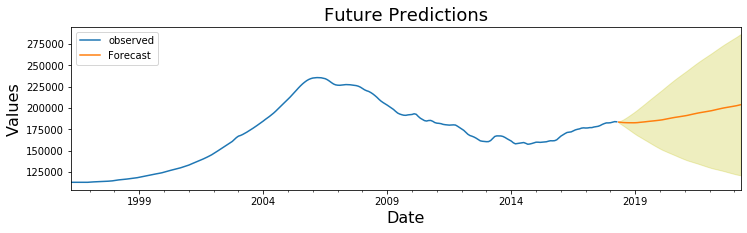

The Mean Squared Error of our forecasts is 242743.71 

The RMSE of our forecasts is 492.69 

The Max/Min Normalized RMSE is 0.3 

The Mean Absolute Percentage Error is 0.24% 

The Current Value is: $ 183700.0 

The Five Year predictions values are:  
             lower value  upper value  mean value
2023-04-01    120978.64    286433.35   203705.99 

The Five Year average change in value: 11.110000000000001 %


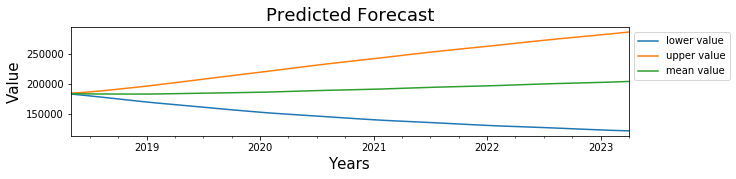

In [101]:
master_function(CT_6382)

# Interpreting Results

After having checked all the correlograms to make sure that the p-d-q values look good I went ahead and ran the SARIMAX models and used the lowest AIC scores to determine the best fit.  I then coded the RMSE values to help me analyze the results of the forecast.

The Rhode Island zip code of 02882 showed the best change in value for the mean of predictions at 34.93% even though it had one of the larger RMSE scores of 1189.54. Yet considering the price of houses for this region were nearly double that of some of the other regions it means that this prediction is still the best.

Conneticut's zip code of 06382 had the best RMSE of 492.69 but also had one of the cheapest housing prices - along with only an 11.11% predicted change in value it seems like not the top choice. It's interesting to note that this zip code is near the ocean but doesn't actually have any ocean-front properties. 

New Hampshire had the worst predicted value and the only forecasted score that was negative of -2.26%. Along with the worst RMSE score of the group of 1682.61! Though it should also be noted that this zip code of 03755 had the most expensive housing market and is probably one of the hardest places to actually currently buy.

The second highest predicted value came from Maine zip code 04105 with a predicted change of 23.88%. This was interesting considering the top two zip codes were along the ocean coast.  Yet again, the RMSE was the second highest of 1496.72 which correlated with having the second highest current house price, but probably not enough to be more conclusive than Rhode Island.


# Conclusion and Recommendation

For investers looking to buy a property in a quaint New England village, where there town sizes are not too small, nor are the towns considered a suburb of a sprawling capital/large city, I have narrowed the field of possibilities and created a model that can forecast with limited certainly the region that is likely to show growth. 

Using my predicted results from my SARIMAX Time Series model and calculated RMSE scores I would recommend the Rhode Island zip code of 02882 as the region with best possibility for investment growth over the next five years. While there certainly are other zip codes around the country and even in New England that may have better growth, only towns with a population of around 10,000 were considered.

# Future Work

I would first like to apply my model to rural towns or the large cities in New England. I would like to focus on zip code demographics or perhaps population density. 

More importantly, I would like to use towns or village names instead of zip code to build my model. In doing research of various regions I discovered that zip code lines tend to be drawn differently than how neighborhoods develop or how real estate values seem to be considered. It is quite possible to find two very different houses in the same zip code with varying degree of price and selectability, for zip code location tends to be much more broad than town or county lines. As well, zip code relates to the population density which I believe is an important factor to consider when buying a house, yet only total population numbers were included in my model.

Outside of investment, a regions schools, employment opportunities, and relationship to tourism are huge factors to consider. These factors can greatly effect the housing market.

For future work I would also consider looking at regions outside of New England, though I really like being able to narrow the field down to a relatively small group of interesting zip codes.